# Read in libraries and set up plotting tools

In [377]:
# edit section below to change how we plot the maze predictions
import os
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle, Arrow, Circle
import matplotlib
import json
import pandas as pd
import numpy as np
import random
from vgc_project.dynamic_vgc import dynamic_vgc
from vgc_project.soft_vgc import soft_value_guided_construal
from vgc_project.construal_search import \
    ConstrualSearch, ExhaustiveSearch, EventListener, BoundedDepthFirstSearch

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')

matplotlib.rcParams['pdf.fonttype'] = 42

mediumblue = np.array(to_rgb('#EB611D'))
gainsboro = np.array(to_rgb('#D7E0E3'))

def value_format(val):
    if val == 0:
        return "0.0"
    elif 0 < val < 1:
        ret =  f"{val:.2f}".lstrip("0")
        if ret == ".00":
            return "0.0"
        elif ret == "1.00":
            return "1.0"
        else:
            return ret
    elif val >= 1:
        return f"{val:.1f}"
    else:
        raise

def calc_obstacle_label_loc(locs, tile_array):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    locs = np.array(locs) + .5
    mean_loc = np.mean(locs, axis=0)
    obs_bbox_center = np.mean([
        [locs[:,0].min(), locs[:, 1].min()],
        [locs[:,0].max(), locs[:, 1].max()]
    ], axis=0)
    agg_loc = mean_loc*.6 + obs_bbox_center*.4
    agg_loc = (
        min(max(1, agg_loc[0]), grid_w - 1),
        min(max(1, agg_loc[1]), grid_h - 1)
    )
    return agg_loc

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue
    
def plot_grid_obstacle_VGC(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    #for side in ['top','right','bottom','left']:
        #ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "012345":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = '#FFFFFF'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .4, y + .5,
                markeredgecolor='#E330A4',
                markerfacecolor='#E330A4',
                marker='o',
                markersize=4.5,
                markeredgewidth=.5,
                fillstyle='full'
            )
        elif loc_feature == "G":
            goal =ax.plot(
                x + .5, y + .5,
                markeredgecolor='green',
                markerfacecolor='green',
                marker='*',
                markersize=6,
                markeredgewidth=0.5,
                fillstyle='full'
            )

        
def plot_grid_obstacle_dVGC(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    #for side in ['top','right','bottom','left']:
        #ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "012345":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = '#FFFFFF'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .4, y + .5,
                markeredgecolor='#E330A4',
                markerfacecolor='#E330A4',
                marker='o',
                markersize=4.5,
                markeredgewidth=.5,
                fillstyle='full'
            )
        elif loc_feature == "G":
            goal =ax.plot(
                x + .5, y + .5,
                markeredgecolor='green',
                markerfacecolor='green',
                marker='*',
                markersize=6,
                markeredgewidth=0.5,
                fillstyle='full'
            )
            #ax.add_patch(goal)
    for obstacle, locs in obstacle_locs.items():
        label_loc = calc_obstacle_label_loc(locs, tile_array)
        text = ax.text(
                  label_loc[0],
                label_loc[1],
                value_format(obstacle_values[obstacle]),
                color='k',
                ha='center',
                va='center_baseline',
                bbox=dict(facecolor='#FEE5D6', edgecolor='#EB611D', linewidth=.5, boxstyle='round,pad=.2'),
                fontdict=dict(font="Arial"),
        )
        text.set_fontsize(5)

#  Read in mazes json files

In [378]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_Lateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

# Iterate through mazes to compute STATIC VGC

In [379]:
from vgc_project.vgc import value_guided_construal

data = []
for maze_name in mazes.keys():
    #print(maze_name)
    VGC_temp=value_guided_construal(tile_array=tuple(mazes[maze_name]),
                           construal_inverse_temp =1/0.1, 
                           feature_rewards=(("G", 0), ),
                           absorbing_features=("G",), 
                           wall_features="#0123456789", 
                           default_features=(".",),
                           initial_features=("S",),
                           step_cost=-1, 
                           discount_rate=1.0-1e-5, 
                           planning_alg="policy_iteration")
    myKeys = list(VGC_temp['obstacle_probs'].keys())
    myKeys.sort()
    sorted_dict = {i: VGC_temp['obstacle_probs'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
df = pd.DataFrame(data)
df.columns =['static_vgc_weight']
df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)


# Now let us add in dynamic VGC to the dataframe

In [380]:

data = []
for maze_name in mazes.keys():
    dVGC_temp= dynamic_vgc(tile_array=tuple(mazes[maze_name]),
                        ground_policy_inv_temp=1/0.1,
                        ground_policy_rand_choose=0.,
                        ground_discount_rate=1.0-1e-5,
                        action_deviation_reward=0,
                        wall_bias=0.,
                        wall_bump_cost=0.,
                        added_obs_cost=1,
                        removed_obs_cost=0,
                        continuing_obs_cost=0,
                        construal_switch_cost=0,
                        switching_inv_temp=5,
                        switching_rand_choose=0.,
                        switching_discount_rate=1-1e-5,
                        max_construal_size=3,
                        n_simulations=1000,
                        seed=112893)
    myKeys = list(dVGC_temp['obs_prob'].keys())
    myKeys.sort()
    sorted_dict = {i: dVGC_temp['obs_prob'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
df.insert(3, "dynamic_vgc_weight", data, True)

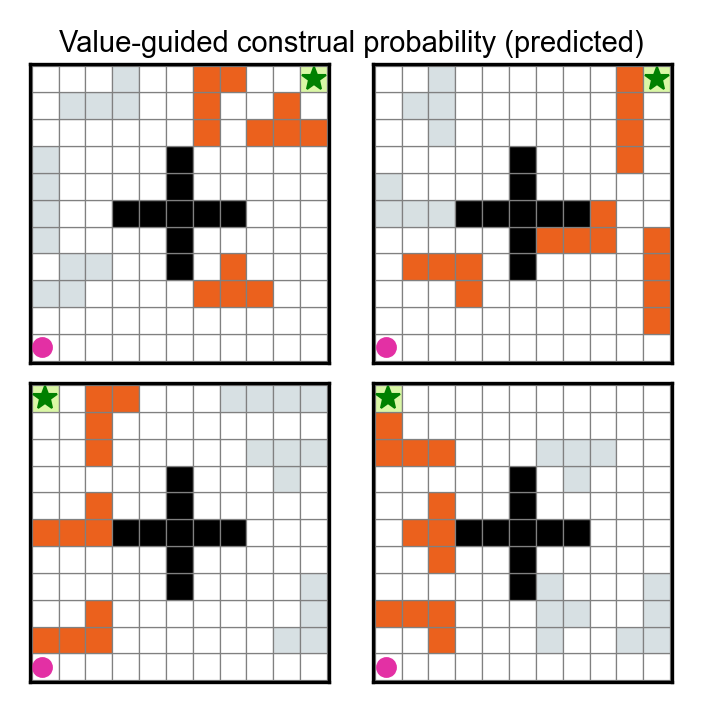

In [144]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_1-4_sVGC.pdf")

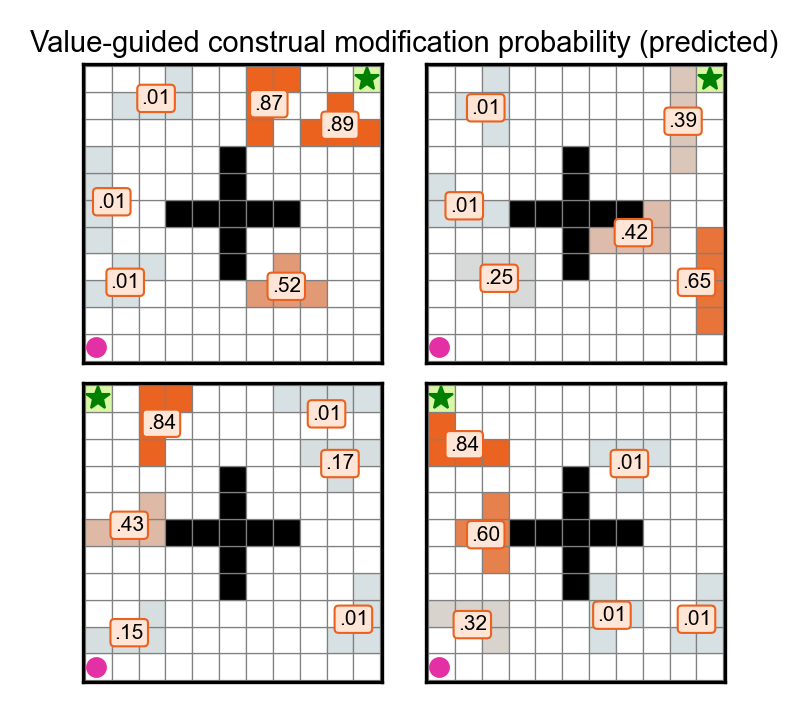

In [145]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_1-4_dVGC.pdf")

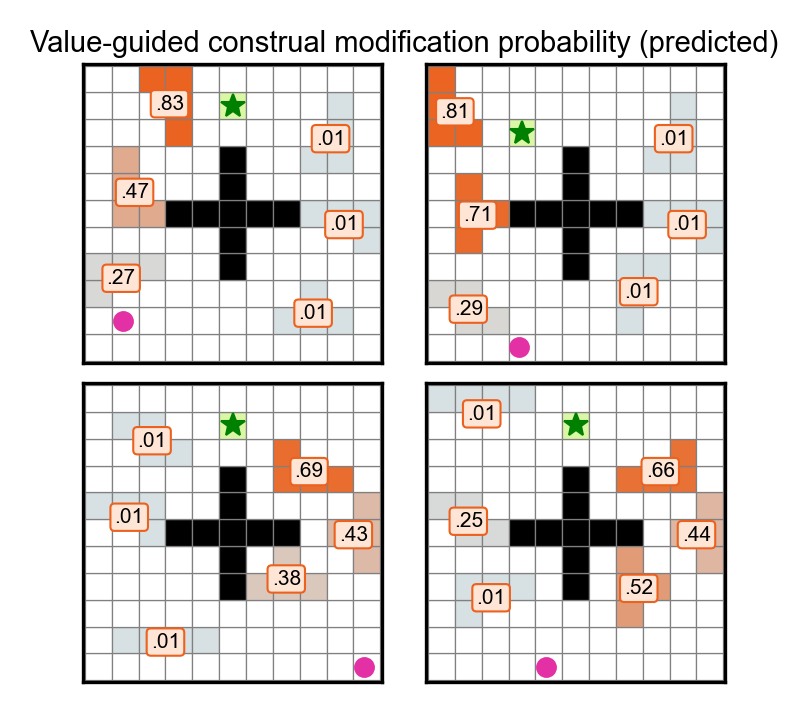

In [146]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_5-8_dVGC.pdf")

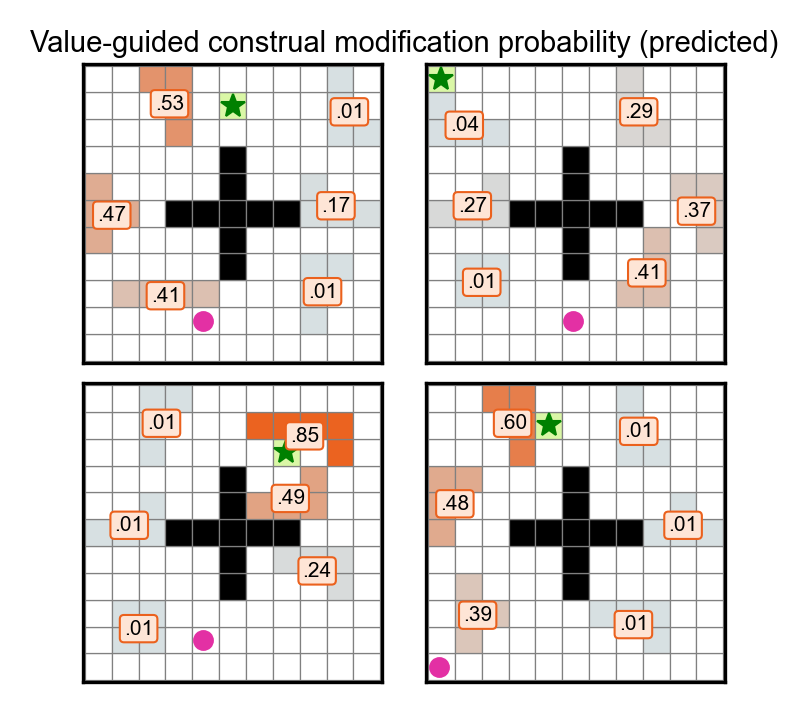

In [147]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_9-12_dVGC.pdf")

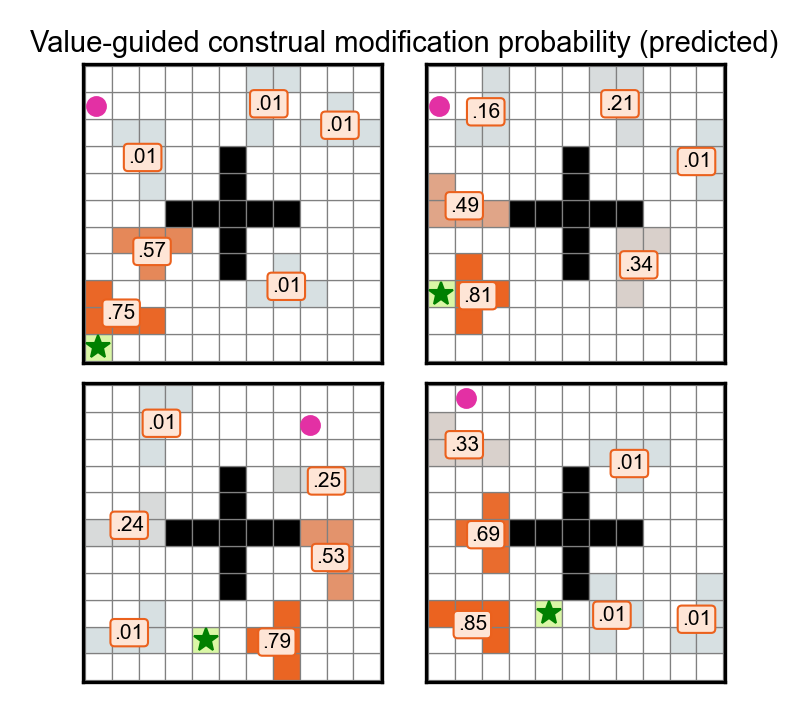

In [137]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [12, 13, 14, 15] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_13-16_dVGC.pdf")

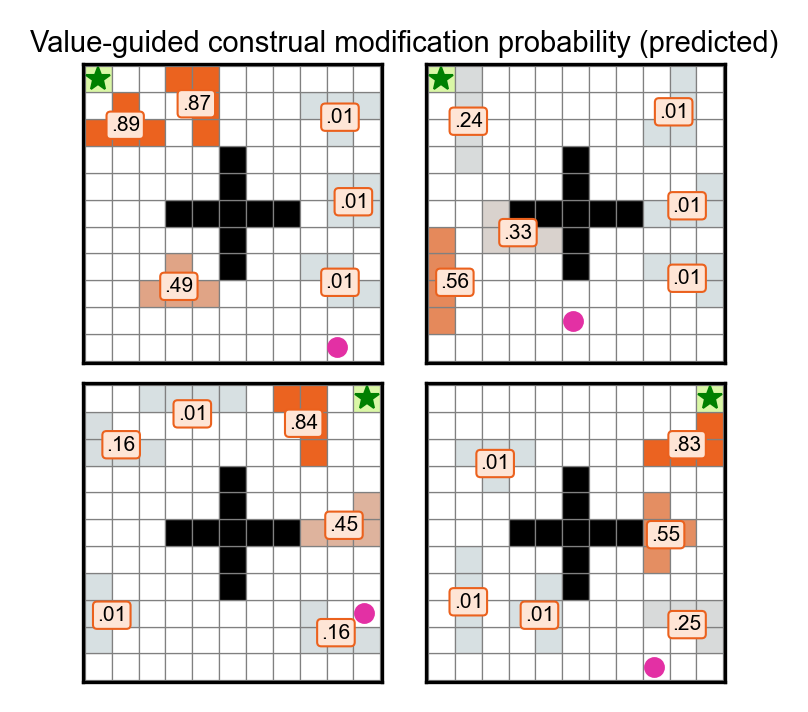

In [138]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [16, 17, 18, 19] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_17-20_dVGC.pdf")

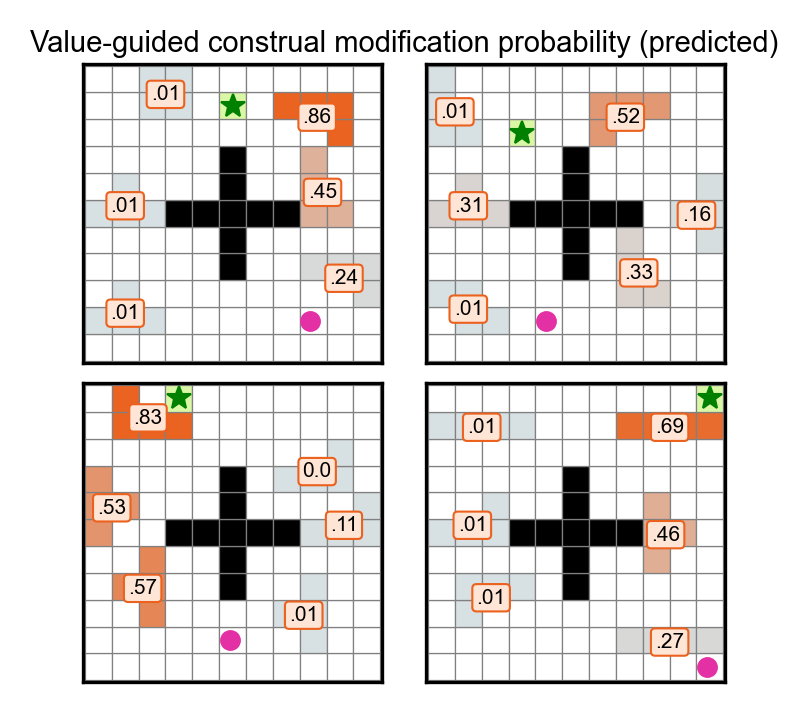

In [139]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [20, 21, 22, 23] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_21-24_dVGC.pdf")

# Let's look at non-lateralized stimuli

In [381]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

In [382]:
from vgc_project.vgc import value_guided_construal

data = []
for maze_name in mazes.keys():
    VGC_temp=value_guided_construal(tile_array=tuple(mazes[maze_name]),
                           construal_inverse_temp =1/0.1, 
                           feature_rewards=(("G", 0), ),
                           absorbing_features=("G",), 
                           wall_features="#0123456789", 
                           default_features=(".",),
                           initial_features=("S",),
                           step_cost=-1, 
                           discount_rate=1.0-1e-5, 
                           planning_alg="policy_iteration")
    myKeys = list(VGC_temp['obstacle_probs'].keys())
    myKeys.sort()
    sorted_dict = {i: VGC_temp['obstacle_probs'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
df_nl = pd.DataFrame(data)
df_nl.columns =['static_vgc_weight']
df_nl.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
df_nl.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)


data = []
for maze_name in mazes.keys():
    dVGC_temp= dynamic_vgc(tile_array=tuple(mazes[maze_name]),
                        ground_policy_inv_temp=1/0.1,
                        ground_policy_rand_choose=0.,
                        ground_discount_rate=1.0-1e-5,
                        action_deviation_reward=0,
                        wall_bias=0.,
                        wall_bump_cost=0.,
                        added_obs_cost=1,
                        removed_obs_cost=0,
                        continuing_obs_cost=0,
                        construal_switch_cost=0,
                        switching_inv_temp=5,
                        switching_rand_choose=0.,
                        switching_discount_rate=1-1e-5,
                        max_construal_size=3,
                        n_simulations=1000,
                        seed=112893)
    myKeys = list(dVGC_temp['obs_prob'].keys())
    myKeys.sort()
    sorted_dict = {i: dVGC_temp['obs_prob'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
df_nl.insert(3, "dynamic_vgc_weight", data, True)

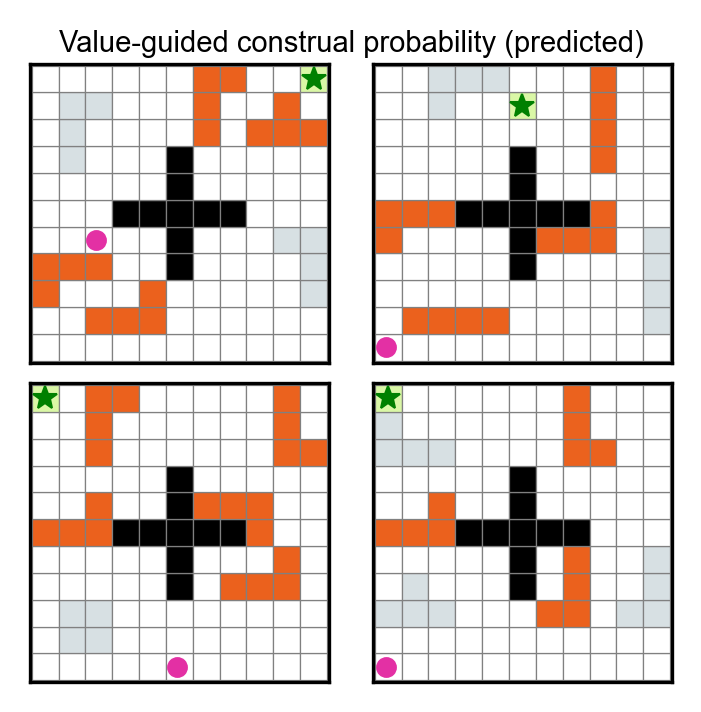

In [263]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_1-4_sVGC.pdf")

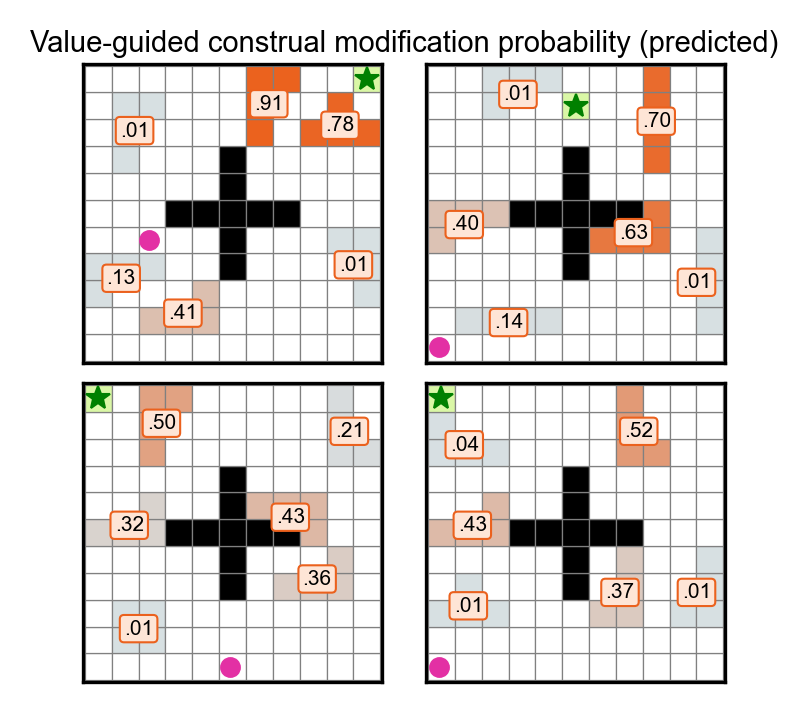

In [264]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_1-4_dVGC.pdf")

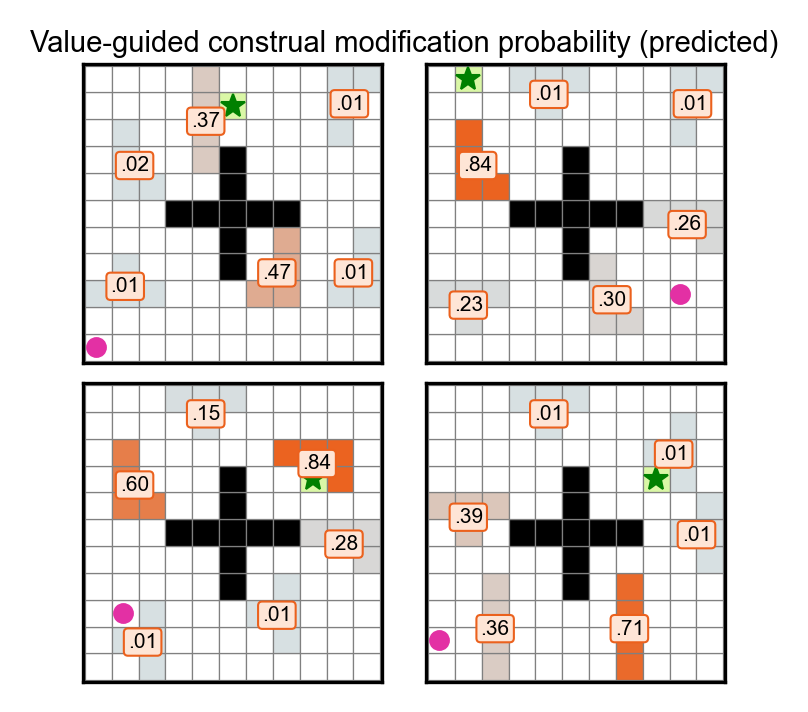

In [265]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_5-8_dVGC.pdf")

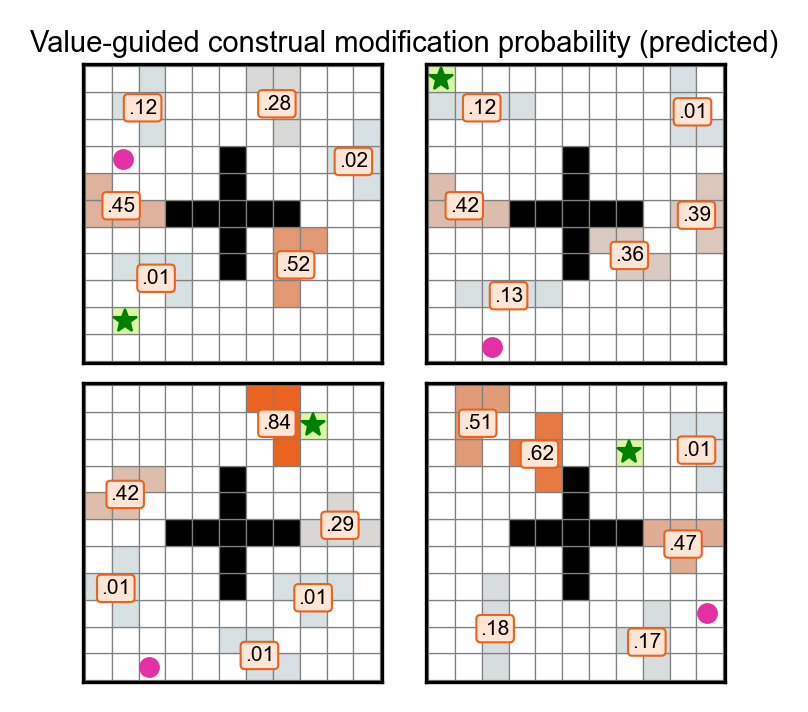

In [266]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_9-12_dVGC.pdf")

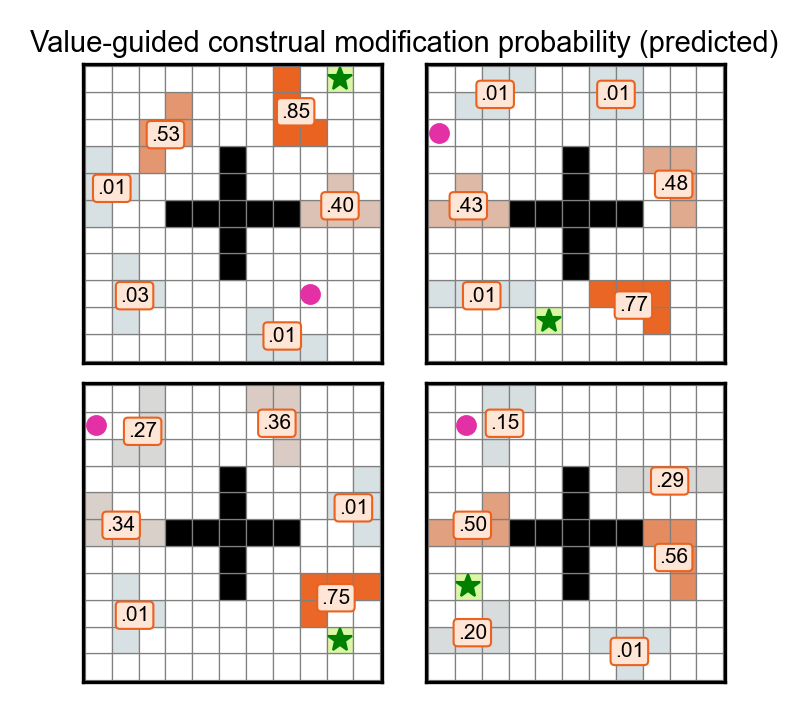

In [267]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [12, 13, 14, 15] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_13-16_dVGC.pdf")

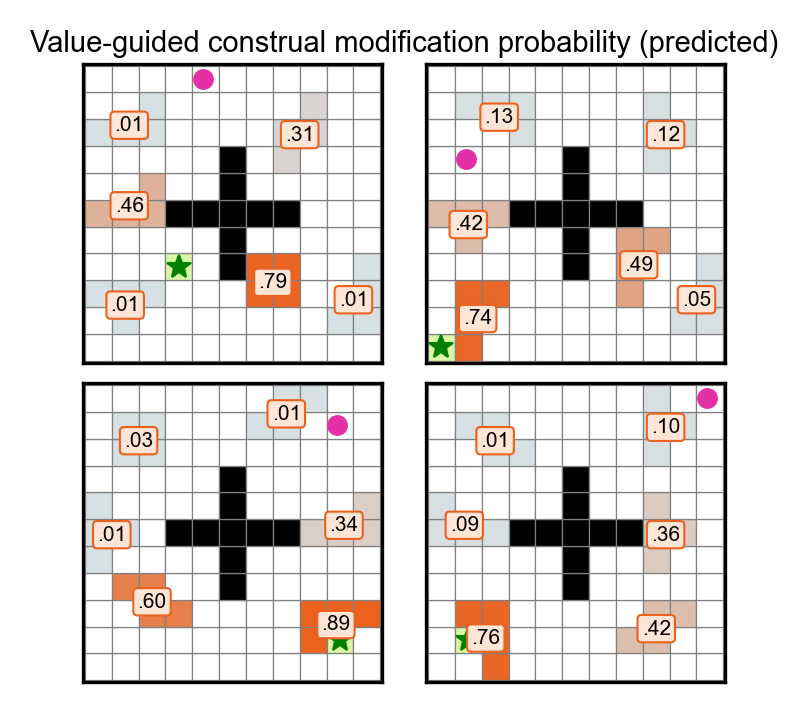

In [268]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [16, 17, 18, 19] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_17-20_dVGC.pdf")

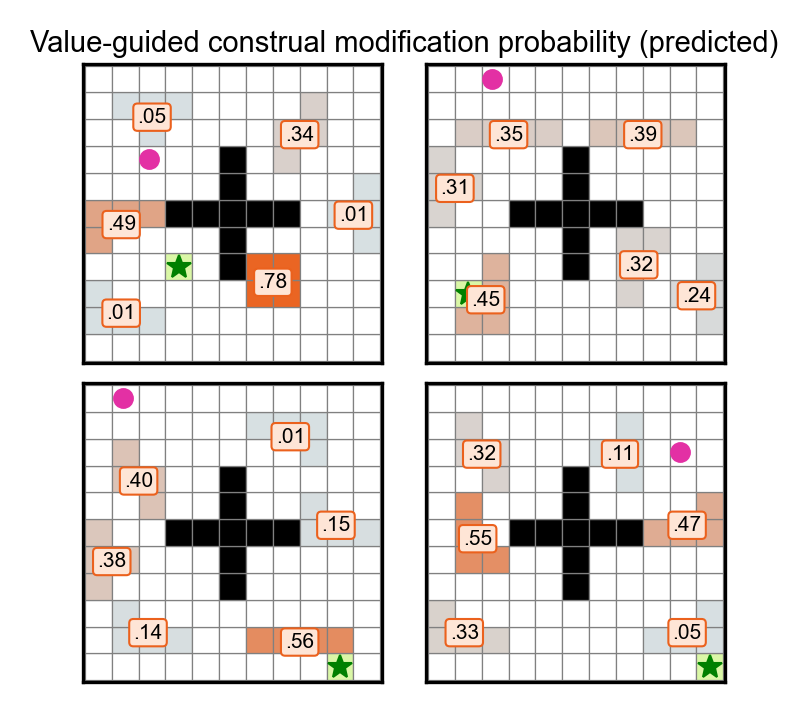

In [272]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [20, 21, 22, 23] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_21-24_dVGC.pdf")

#  Now let us check if heuristics differ between the later & non-lat mazes

In [397]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_Lateralized.json", 'r')),
    **json.load(open("../../experiments/mazes/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

goal = []
start = []
wall = []
center = []

from vgc_project import maze_stats
for maze_name in mazes.keys():
    maze_obs_stats=maze_obstacle_statistics(tile_array=tuple(mazes[maze_name]),
                                            n_simulations=100,
                                            feature_rewards=(("G", 0), ),
                                            absorbing_features=("G",),
                                            wall_features="#0123456789",
                                            default_features=(".",),
                                            initial_features=("S",),
                                            step_cost=-1,
                                            discount_rate=1.0)
    myKeys = list(maze_obs_stats['goal_mindist'].keys())
    myKeys.sort()
    sorted_dict = {i: maze_obs_stats['goal_mindist'][i] for i in myKeys}
    goal.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['start_mindist'][i] for i in myKeys}
    start.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['walls_mindist'][i] for i in myKeys}
    wall.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['center_mindist'][i] for i in myKeys}
    center.extend(list(sorted_dict.values()))
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
    
maze_stats_df= pd.DataFrame(goal)
maze_stats_df.columns =['goal_dist']
maze_stats_df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
maze_stats_df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)
maze_stats_df.insert(3, "start_dist", start, True)
maze_stats_df.insert(4, "wall_dist", wall, True)
maze_stats_df.insert(5, "center_dist", center, True)
maze_stats_df.insert(6, "lateralized", np.repeat(list([1,0]), 6*24), True)
maze_stats_df.insert(7, "dVGC", list(df['dynamic_vgc_weight']) + list(df_nl['dynamic_vgc_weight']), True)
maze_stats_df.insert(8, "sVGC", list(df['static_vgc_weight']) + list(df_nl['static_vgc_weight']), True)


# save to csv for plotting in R
maze_stats_df.to_csv('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/new_mazes_stats.csv')

In [398]:
# permutation t-test indepn samples, two tailed, to test for diff between lateralized vs non-lateralized 
import scipy
print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "goal_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "goal_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "start_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "start_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "wall_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "center_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "center_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

TtestResult(statistic=0.1601777707232336, pvalue=0.8941058941058941, df=nan)
TtestResult(statistic=0.6894815229628504, pvalue=0.48451548451548454, df=nan)
TtestResult(statistic=0.044324220717792046, pvalue=1.0, df=nan)
TtestResult(statistic=0.04319595738587755, pvalue=0.998001998001998, df=nan)


In [400]:
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "goal_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "start_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))

PearsonRResult(statistic=-0.5927844248922447, pvalue=4.982086183971186e-15)
PearsonRResult(statistic=-0.01902544600598742, pvalue=0.8209400542467814)
PearsonRResult(statistic=-0.04103863473991251, pvalue=0.6252825355989754)
PearsonRResult(statistic=-0.04103863473991251, pvalue=0.6252825355989754)


In [412]:
from vgc_project.successor_rep import successor_representation


os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_0-11.json", 'r'))
}
heutristic_sr=successor_representation(tile_array=tuple(mazes['grid-0-0']),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#0123456789",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)

myKeys = list(heutristic_sr['obstacle_occupancy'].keys())
myKeys.sort()
sorted_dict = {i: heutristic_sr['obstacle_occupancy'][i] for i in myKeys}
list(sorted_dict.values())[1:8]

{'#': 0.0, '0': 0.763313297195472, '1': 1.3125131251312512, '2': 1.3906389063890638, '3': 0.3159211279612796, '4': 0.6153168221135337, '5': 0.012695439454394546, '6': 0.11718867188671886, 'G': 1.0, 'S': 1.000010000100001}


[0.763313297195472,
 1.3125131251312512,
 1.3906389063890638,
 0.3159211279612796,
 0.6153168221135337,
 0.012695439454394546,
 0.11718867188671886]

In [419]:

from vgc_project.successor_rep import optimal_bottleneck


os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_0-11.json", 'r'))
}
heutristic_bottle=optimal_bottleneck(tile_array=tuple(mazes['grid-0-0']),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#0123456789",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)
heutristic_bottle['min_general_bottleneck_distances']

#myKeys = list(heutristic_sr['obstacle_occupancy'].keys())
#myKeys.sort()
#sorted_dict = {i: heutristic_sr['obstacle_occupancy'][i] for i in myKeys}
#list(sorted_dict.values())[1:8]

{'3': 11,
 '0': 7,
 'G': 12,
 '4': 7,
 '6': 9,
 '#': 3,
 '1': 5,
 '2': 1,
 '5': 1,
 'S': 6}

In [453]:

from heuristic_search import trajectory_based_heuristic_search
import math
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_0-11.json", 'r'))
}
heutristic_traj=trajectory_based_heuristic_search(tile_array=tuple(mazes['grid-8-0']),
                                                    seed=1111,
                                                    n_simulations=1000,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#0123456",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
temp=heutristic_traj['mean_hit_counts']
print(heutristic_traj['mean_hit_counts'])



{'0': 0.0, '1': 0.0, '2': 3.678, '3': 1.766, '4': 0.0, '5': 0.0, '6': 1.847, '7': 0.0, '8': 0.0, '9': 0.0}


In [ ]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazes_Lateralized.json", 'r')),
    **json.load(open("../../experiments/mazes/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

heu_graph = []
heu_sr = []
heu_bottle = []
heu_traj = []

from vgc_project.heuristic_search import graph_based_heuristic_search
from vgc_project.successor_rep import optimal_bottleneck
from vgc_project.successor_rep import successor_representation

for maze_name in mazes.keys():
    heutristic_graph= graph_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=100,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#0123456",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_graph['mean_hit_counts'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_graph['mean_hit_counts'][i] for i in myKeys}
    heu_graph.extend(list(sorted_dict.values()))
    heutristic_sr=successor_representation(tile_array=tuple(mazes[maze_name]),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#0123456",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)

    myKeys = list(heutristic_sr['obstacle_occupancy'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_sr['obstacle_occupancy'][i] for i in myKeys}
    heu_sr.extend(list(sorted_dict.values())[1:8])
    
    heutristic_bottle=optimal_bottleneck(tile_array=tuple(mazes[maze_name]),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#0123456",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)
    myKeys = list(heutristic_bottle['min_general_bottleneck_distances'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_bottle['min_general_bottleneck_distances'][i] for i in myKeys}
    heu_bottle.extend(list(sorted_dict.values()))
    
    heutristic_traj=trajectory_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=1000,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#0123456",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_traj['mean_hit_counts'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_traj['mean_hit_counts'][i] for i in myKeys}
    heu_traj.extend(list(sorted_dict.values()))

    
    
    
maze_stats_df= pd.DataFrame(heu_graph)
maze_stats_df.columns =['heu_graph']
maze_stats_df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
maze_stats_df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)
maze_stats_df.insert(3, "heu_sr", heu_sr, True)
maze_stats_df.insert(4, "heu_bottleneck", heu_bottle, True)
maze_stats_df.insert(5, "heu_traj", heu_traj, True)

